<a href="https://colab.research.google.com/github/hrithik2105/BrainTumorClassification/blob/main/BrainTumorDetection(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Essential Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from PIL import Image
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Data Pre-Processing

Initializing OneHotEncoder where 0 is encoded as no tumor(normal) and 1 is encoded as tumor

In [3]:
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(np.array([0, 1]).reshape(-1, 1))

OneHotEncoder(sparse_output=False)

First, we create a data list for storing image data in numpy array form (data).

Secondly, we create a paths list for storing paths of all images (paths).

Thirdly, we create result list for storing one hot encoded form of target class whether normal or tumor.

The label 0 (no tumor) is transformed into [1, 0] (one-hot encoding).

The label 1 (tumor) is transformed into [0, 1] (one-hot encoding).

In [4]:
data = []
paths = []
result = []

yes_path = '/content/drive/MyDrive/brain_tumor_dataset/yes'
for root, dirs, files in os.walk(yes_path):
    for file in files:
        if file.endswith('.jpg'):
            full_path = os.path.join(root, file)
            try:
                img = Image.open(full_path).resize((128, 128)).convert('RGB')
                img_array = np.array(img)
                if img_array.shape == (128, 128, 3):
                    data.append(img_array)
                    result.append(encoder.transform([[1]])[0])  # 1 = YES → [0, 1]
                    paths.append(full_path)
            except Exception as e:
                print(f"Error processing {full_path}: {e}")

In [5]:
no_path = '/content/drive/MyDrive/brain_tumor_dataset/no'
for root, dirs, files in os.walk(no_path):
    for file in files:
        if file.endswith('.jpg'):
            full_path = os.path.join(root, file)
            try:
                img = Image.open(full_path).resize((128, 128)).convert('RGB')
                img_array = np.array(img)
                if img_array.shape == (128, 128, 3):
                    data.append(img_array)
                    result.append(encoder.transform([[0]])[0])  # 0 = NO → [1, 0]
                    paths.append(full_path)
            except Exception as e:
                print(f"Error processing {full_path}: {e}")

In [6]:
data = np.array(data)
data.shape

(171, 128, 128, 3)

In [7]:
print(f'Total number of images we have: {len(data)}')

Total number of images we have: 171


In [9]:
result = np.array(result)
result = result.reshape(171,2)

# Spliting the dataset for training and testing

In [10]:
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

In [11]:
print(f'Number of images in training data: {len(x_train)}')

Number of images in training data: 136


In [12]:
print(f'Number of images in testing data: {len(x_test)}')

Number of images in testing data: 35


# Building the CNN model

Sequential() is used to stack the layers.

We create a convolutional layer with number of filters(weights) = 32 and has a filter size of (2,2). This filter will convolve across the image (basically takes the dot product with the input image).

Then, we stack the RELU activation infront of it. RELU basically makes the negative weights as 0 (inclusive) so that only the positive weights are considered.

Later, we stack a batch normalization layer which basically subtracts each weight with the mean of the batch and divides by the std-deviation (sqrt of Variance). This is done as to normalize the outputs from the RELU to a standard scale.  

Penultimately, Max pooling is done with the pool size of (2,2) which basically takes the highest values from each 2x2 pool. This basically reduces the the overall dimension by a factor of 2. This process makes up for efficient and faster computation while preserving the most important features.

Finally, Dropout is performed to make all the weights active(prevents some filters from being dependent on others) and this also prevents overfitting. A factor of 0.25 is chosen meaning that on average, 25% of the random output weights are set to 0.

This whole process is repeated twice.

Flattenning is done which transforms the weights into a single dimension.

We then add a Feed Forward Dense Neural Network layer(512) which is another core component in the CNN and has most of the weights. RELU activation is once again performed and so is Dropout(50%)


Ultimately, a non-linear activation such as Softmax(multi class) or Sigmoid(binary class) is added to classify the image based on probability (softmax).


Loss: Categorical Cross Entropy because we dont want other probaility values to be considered apart from the correct ones during training (forward and backward pass).

In [13]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,585,602 (128.12 MB)

 Trainable params: 33,585,410 (128.12 MB)

 Non-trainable params: 192 (768.00 B)

None


In [14]:
y_train.shape

(136, 2)

# Training the CNN model

In [15]:
history = model.fit(x_train, y_train, epochs = 30, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 24.5836 - val_loss: 83.0586
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 14.0807 - val_loss: 18.5602
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 6.4648 - val_loss: 8.0727
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.3715 - val_loss: 5.8218
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.6822 - val_loss: 7.4744
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.8716 - val_loss: 9.6354
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.6269 - val_loss: 5.9586
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.4831 - val_loss: 5.7171
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.6490 - val_loss: 5.9760
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0587 - val_loss: 6.1235
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2040 - val_loss: 5.4973
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0428 - val_loss: 5.020

Plotting the Validation and Test Loss

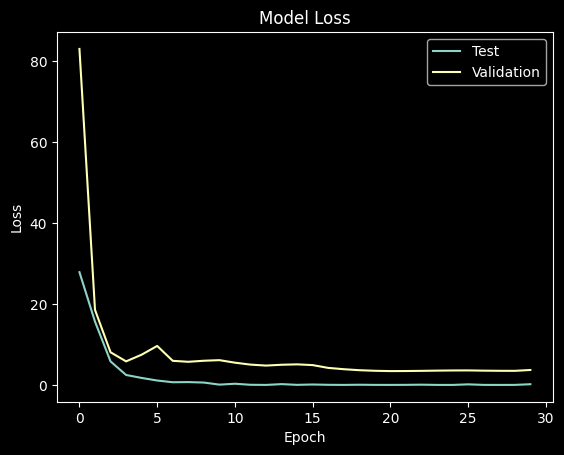

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

We can observe that they approach a straight line which indicates that no further training is required and also we can observe that validation loss is slightly more than the test loss which means that our model can generalize and classify images very well and also indicates no overfitting.

# Verifying the Results

In [19]:
def names(number):
    return 'No, It\'s not a tumor' if number == 0 else 'It\'s a Tumor'

99.889755% Confidence This Is No, It's not a tumor


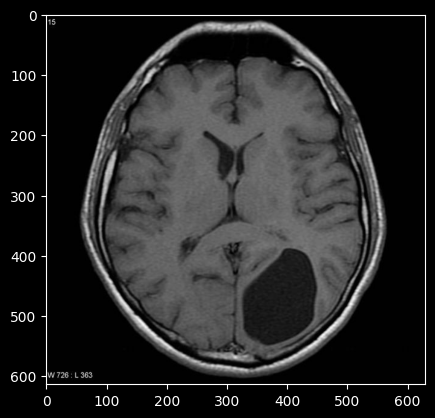

In [20]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/My Drive/brain_tumor_dataset/no/N11.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))

100.0% Confidence This Is A It's a Tumor


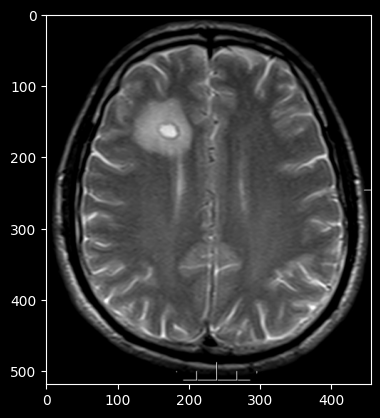

In [21]:
img = Image.open(r"/content/drive/My Drive/brain_tumor_dataset/yes/Y3.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is A ' + names(classification))

# Building a sharable application using Gradio

In [23]:
#@title Provide a title for your app:
heading_title = "Hrithik's brain tumor classification app" # @param {type:"string"}

In [25]:
#@title Number of Example images to be present in the app by default. The user can see use these images to quickly and easily test the model.
num_examples = 6 # @param {type:"slider", min:1, max:6, step:1}

example_path_1:  /content/drive/My Drive/brain_tumor_dataset/yes/Y101.jpg
example_path_2:  /content/drive/My Drive/brain_tumor_dataset/yes/Y102.jpg
example_path_3:  /content/drive/My Drive/brain_tumor_dataset/no/N17.jpg
example_path_4:  /content/drive/My Drive/brain_tumor_dataset/yes/Y103.jpg
example_path_5:  /content/drive/MyDrive/brain_tumor_dataset/no/No22.jpg
example_path_6:  /content/drive/MyDrive/brain_tumor_dataset/no/no 8.jpg


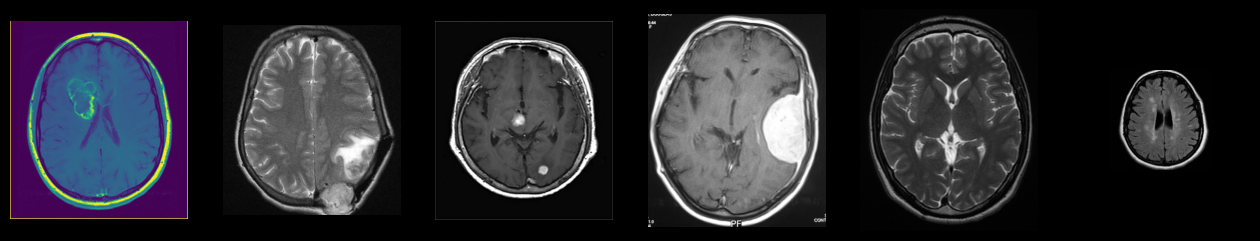

In [27]:
examples=[]
for i in range(num_examples):
  example_path = input(f"example_path_{i+1}:  ")
  examples.append(example_path)

#Displaying the selected images side by side
rows = 1
plt.figure(figsize=(16, 8))
for num, x in enumerate(examples):
    img = Image.open(x)
    plt.subplot(rows,6,num+1)
   # plt.title(x.split('.')[0])
    plt.axis('off')
    plt.imshow(img)

In [31]:
!pip install gradio
import gradio as gr

#@title Selecting a Theme for Gradio Interface:
theme_selection = "Monochrome" # @param ["Base", "Default", "Glass", "Monochrome", "Soft"]

theme_dict = {
    "Base": gr.themes.Base(),
    "Default": gr.themes.Default(),
    "Glass": gr.themes.Glass(),
    "Monochrome": gr.themes.Monochrome(),
    "Soft": gr.themes.Soft()
}

# The selected theme is determined by the user's dropdown selection
selected_theme = theme_dict[theme_selection]

# Now you can use the selected_theme variable when you create your Gradio interface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.1 MB/s eta 0:00:00


Adding components and launching the application

In [32]:
def recognize_image(image):
    # Resize the image to the expected dimensions
    img = Image.fromarray(image).resize((128, 128))
    # Convert the image to a NumPy array
    x = np.array(img)
    # Reshape the image to match the model input
    x = x.reshape(1, 128, 128, 3)

    # Make a prediction
    res = model.predict_on_batch(x)
    classification = np.where(res == np.amax(res))[1][0]

    # Map the class index to the actual class name (assuming you have a list of class names)
    class_names = ['No Tumor', 'Tumor']  # Example class names, update according to your model
    result = f"{names(classification)}"

    return result

In [ ]:
# Assuming recognize_image, examples, heading_title, desc, long_desc, and selected_theme are defined elsewhere.

# Update the import for components
image = gr.Image()
label = gr.Label()

# Create the interface with the updated component imports
iface = gr.Interface(
    fn=recognize_image,
    inputs=image,
    outputs=label,
    examples=examples,
    title=heading_title,
    theme=selected_theme  # Make sure this is defined based on user selection as explained in previous messages
)

iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://bbf4b41db44f94b42e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
